In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128

#Downloads datasets
image_size = (32, 32)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616])])
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [3]:
#Defines class for a residual block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        out = F.relu(x)
        return out


In [26]:
#Defines Convolutional Neural Network

class CNN(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Sets size of network. Paper uses n = {3,5,7,9}, but starting with smallest at 3
        n = 3

        for _ in range(n-1):
            self.reslayers.append(ConvBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ConvBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ConvBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ConvBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ConvBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [23]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 50
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if (batch_index+1) % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0

    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [6]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch50, Loss: 2.280, Accuracy: 14.2%
Batch100, Loss: 2.127, Accuracy: 23.5%
Batch150, Loss: 2.031, Accuracy: 27.7%
Batch200, Loss: 1.945, Accuracy: 32.8%
Batch250, Loss: 1.907, Accuracy: 33.8%
Batch300, Loss: 1.861, Accuracy: 35.9%
Val Loss: 1.836, Val Accuracy: 35.6%
*****************************************



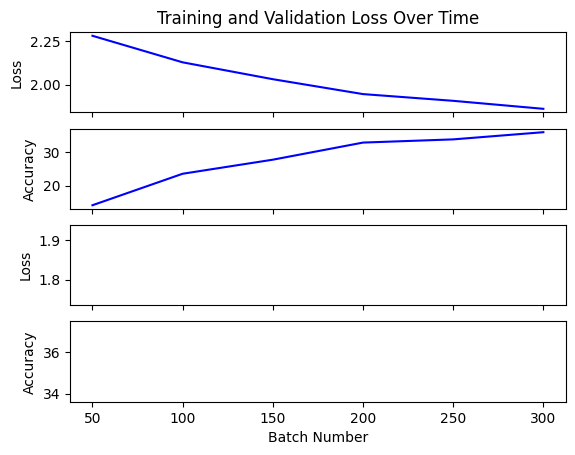

Epoch 2
Batch50, Loss: 1.779, Accuracy: 39.5%
Batch100, Loss: 1.739, Accuracy: 41.3%
Batch150, Loss: 1.697, Accuracy: 42.9%
Batch200, Loss: 1.668, Accuracy: 43.8%
Batch250, Loss: 1.649, Accuracy: 44.0%
Batch300, Loss: 1.639, Accuracy: 44.6%
Val Loss: 1.662, Val Accuracy: 42.7%
*****************************************



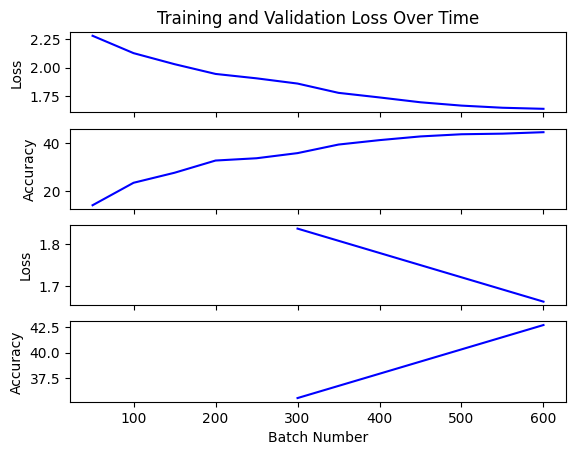

Epoch 3
Batch50, Loss: 1.552, Accuracy: 48.1%
Batch100, Loss: 1.541, Accuracy: 48.1%
Batch150, Loss: 1.507, Accuracy: 49.2%
Batch200, Loss: 1.548, Accuracy: 47.7%
Batch250, Loss: 1.483, Accuracy: 49.5%
Batch300, Loss: 1.412, Accuracy: 52.0%
Val Loss: 1.475, Val Accuracy: 49.5%
*****************************************



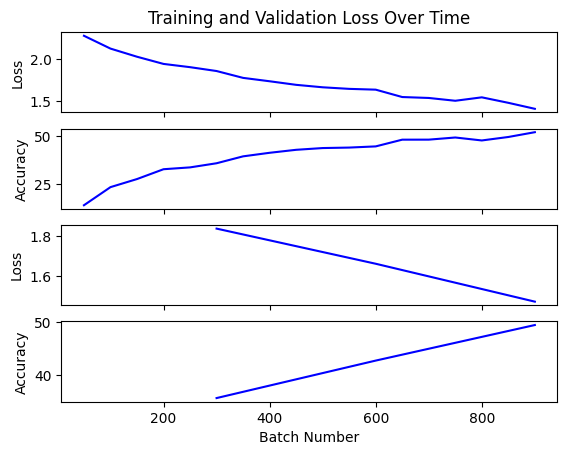

Epoch 4
Batch50, Loss: 1.339, Accuracy: 54.9%
Batch100, Loss: 1.314, Accuracy: 55.7%
Batch150, Loss: 1.288, Accuracy: 57.0%
Batch200, Loss: 1.278, Accuracy: 56.5%
Batch250, Loss: 1.239, Accuracy: 58.4%
Batch300, Loss: 1.225, Accuracy: 58.1%
Val Loss: 1.309, Val Accuracy: 54.2%
*****************************************



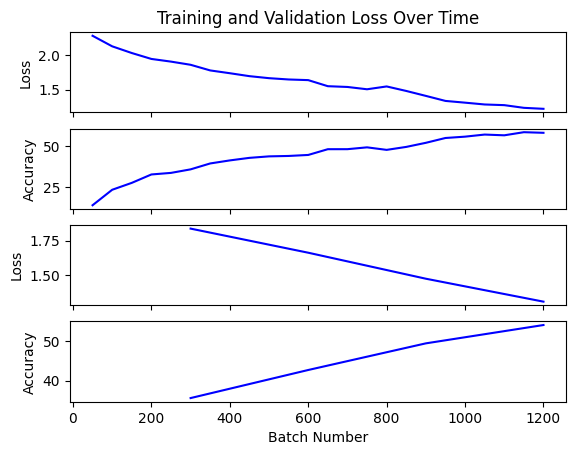

Epoch 5
Batch50, Loss: 1.159, Accuracy: 60.9%
Batch100, Loss: 1.146, Accuracy: 61.6%
Batch150, Loss: 1.149, Accuracy: 61.1%
Batch200, Loss: 1.147, Accuracy: 61.1%
Batch250, Loss: 1.132, Accuracy: 61.1%
Batch300, Loss: 1.139, Accuracy: 61.4%
Val Loss: 1.240, Val Accuracy: 56.2%
*****************************************



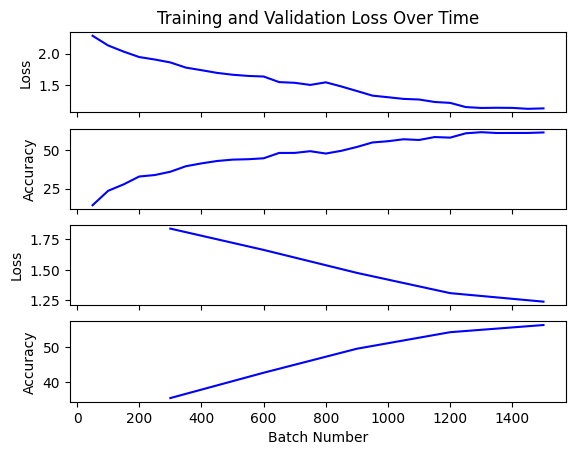

Epoch 6
Batch50, Loss: 1.044, Accuracy: 64.5%
Batch100, Loss: 1.066, Accuracy: 63.1%
Batch150, Loss: 1.055, Accuracy: 64.4%
Batch200, Loss: 1.048, Accuracy: 64.2%
Batch250, Loss: 1.036, Accuracy: 65.5%
Batch300, Loss: 1.030, Accuracy: 64.7%
Val Loss: 1.251, Val Accuracy: 55.8%
*****************************************



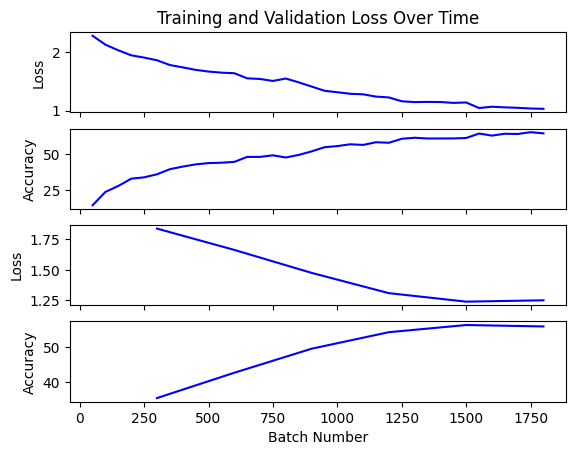

Epoch 7
Batch50, Loss: 0.947, Accuracy: 68.7%
Batch100, Loss: 0.944, Accuracy: 68.6%
Batch150, Loss: 0.967, Accuracy: 67.8%
Batch200, Loss: 0.947, Accuracy: 68.3%
Batch250, Loss: 0.944, Accuracy: 67.7%
Batch300, Loss: 0.959, Accuracy: 67.2%
Val Loss: 1.131, Val Accuracy: 60.3%
*****************************************



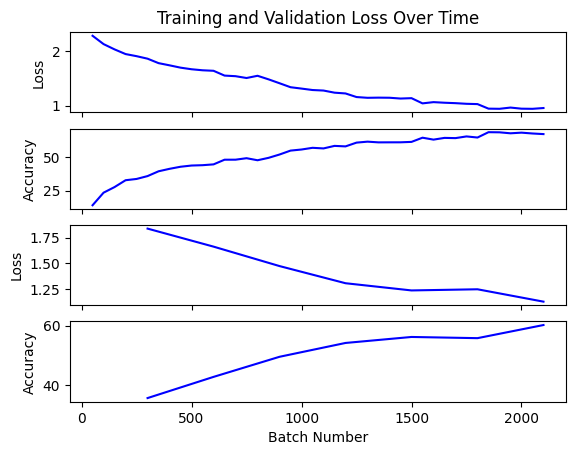

Epoch 8
Batch50, Loss: 0.837, Accuracy: 72.7%
Batch100, Loss: 0.877, Accuracy: 70.5%
Batch150, Loss: 0.900, Accuracy: 69.6%
Batch200, Loss: 0.895, Accuracy: 70.5%
Batch250, Loss: 0.864, Accuracy: 71.4%
Batch300, Loss: 0.872, Accuracy: 70.5%
Val Loss: 1.157, Val Accuracy: 59.6%
*****************************************



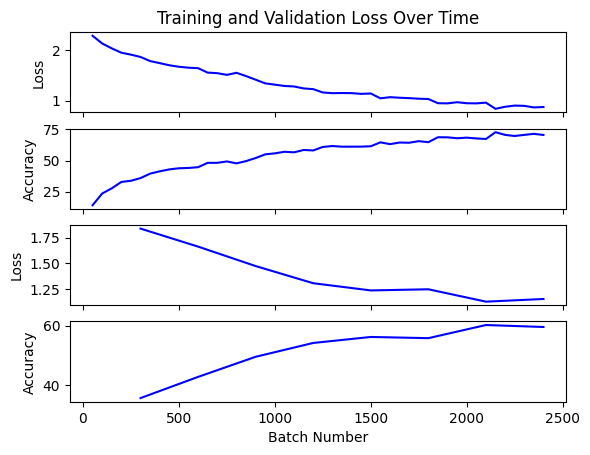

Epoch 9
Batch50, Loss: 0.785, Accuracy: 73.6%
Batch100, Loss: 0.808, Accuracy: 73.6%
Batch150, Loss: 0.812, Accuracy: 72.7%
Batch200, Loss: 0.785, Accuracy: 73.4%
Batch250, Loss: 0.794, Accuracy: 73.7%
Batch300, Loss: 0.837, Accuracy: 71.7%
Val Loss: 1.097, Val Accuracy: 61.4%
*****************************************



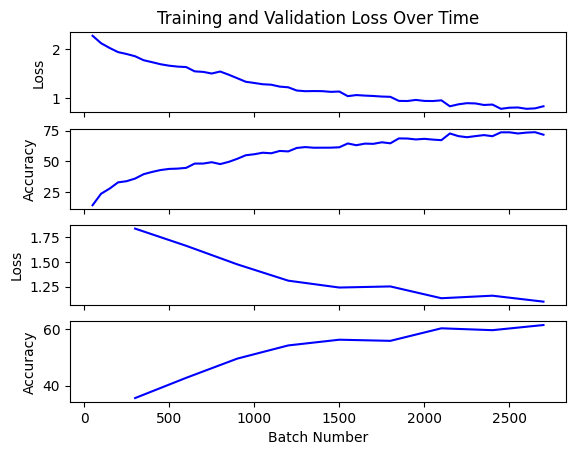

Epoch 10
Batch50, Loss: 0.726, Accuracy: 76.6%
Batch100, Loss: 0.724, Accuracy: 76.1%
Batch150, Loss: 0.739, Accuracy: 75.0%
Batch200, Loss: 0.732, Accuracy: 75.8%
Batch250, Loss: 0.745, Accuracy: 74.9%
Batch300, Loss: 0.750, Accuracy: 74.8%
Val Loss: 1.137, Val Accuracy: 61.0%
*****************************************



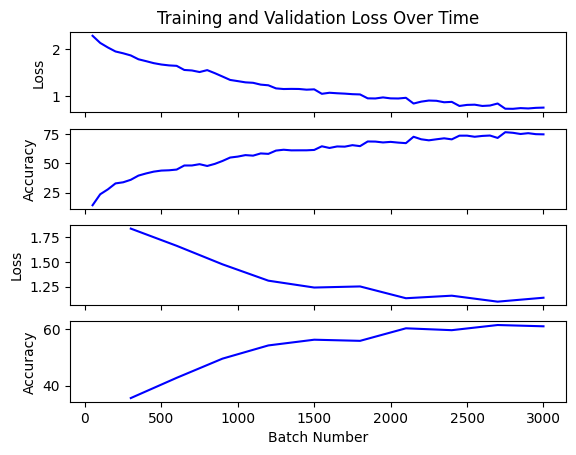

Epoch 11
Batch50, Loss: 0.657, Accuracy: 78.5%
Batch100, Loss: 0.636, Accuracy: 79.5%
Batch150, Loss: 0.659, Accuracy: 78.8%
Batch200, Loss: 0.704, Accuracy: 77.0%
Batch250, Loss: 0.681, Accuracy: 77.1%
Batch300, Loss: 0.698, Accuracy: 76.9%
Val Loss: 1.146, Val Accuracy: 62.0%
*****************************************



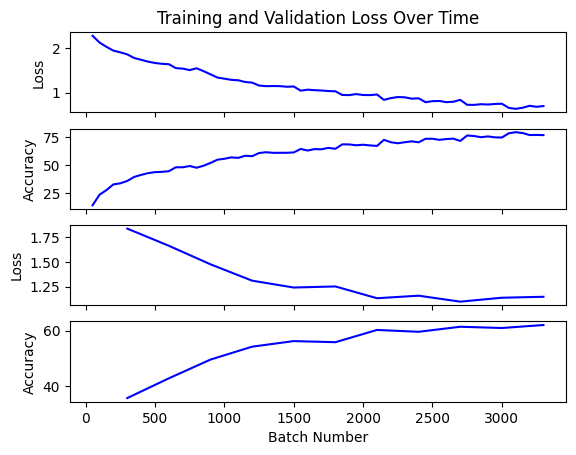

Epoch 12
Batch50, Loss: 0.597, Accuracy: 80.4%
Batch100, Loss: 0.589, Accuracy: 81.0%
Batch150, Loss: 0.610, Accuracy: 80.2%
Batch200, Loss: 0.597, Accuracy: 80.6%
Batch250, Loss: 0.601, Accuracy: 80.1%
Batch300, Loss: 0.666, Accuracy: 78.3%
Val Loss: 1.209, Val Accuracy: 60.3%
*****************************************



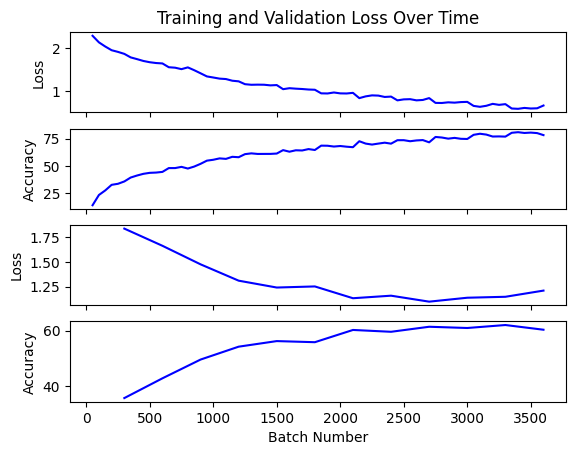

Epoch 13
Batch50, Loss: 0.543, Accuracy: 82.7%
Batch100, Loss: 0.554, Accuracy: 82.3%
Batch150, Loss: 0.580, Accuracy: 81.2%
Batch200, Loss: 0.565, Accuracy: 81.4%
Batch250, Loss: 0.564, Accuracy: 81.3%
Batch300, Loss: 0.573, Accuracy: 81.3%
Val Loss: 1.152, Val Accuracy: 62.2%
*****************************************



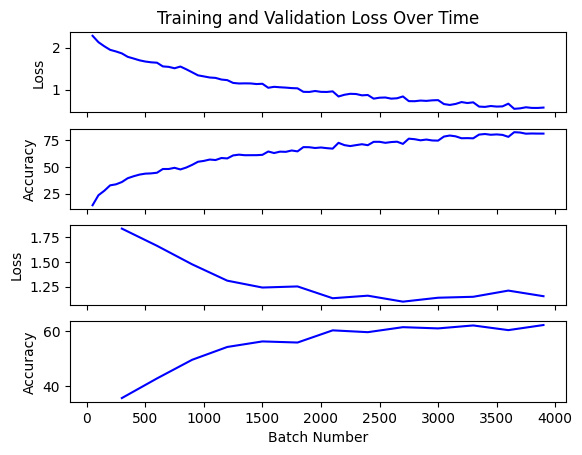

Epoch 14
Batch50, Loss: 0.490, Accuracy: 84.1%
Batch100, Loss: 0.500, Accuracy: 83.9%
Batch150, Loss: 0.506, Accuracy: 83.8%
Batch200, Loss: 0.504, Accuracy: 83.5%
Batch250, Loss: 0.489, Accuracy: 84.8%
Batch300, Loss: 0.539, Accuracy: 82.1%
Val Loss: 1.224, Val Accuracy: 60.9%
*****************************************



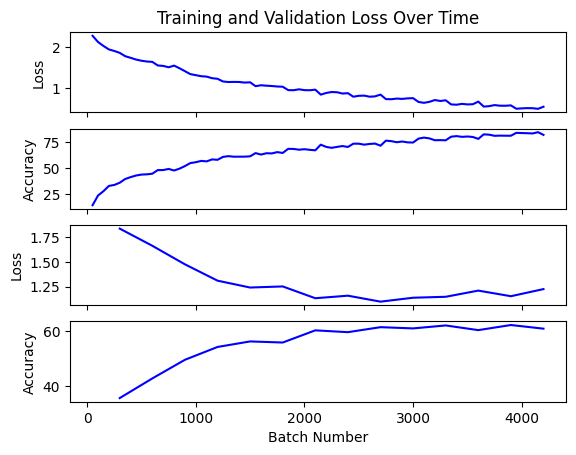

Epoch 15
Batch50, Loss: 0.434, Accuracy: 86.8%
Batch100, Loss: 0.440, Accuracy: 86.0%
Batch150, Loss: 0.453, Accuracy: 85.5%
Batch200, Loss: 0.473, Accuracy: 84.7%
Batch250, Loss: 0.469, Accuracy: 85.2%
Batch300, Loss: 0.480, Accuracy: 84.7%
Val Loss: 1.171, Val Accuracy: 62.7%
*****************************************



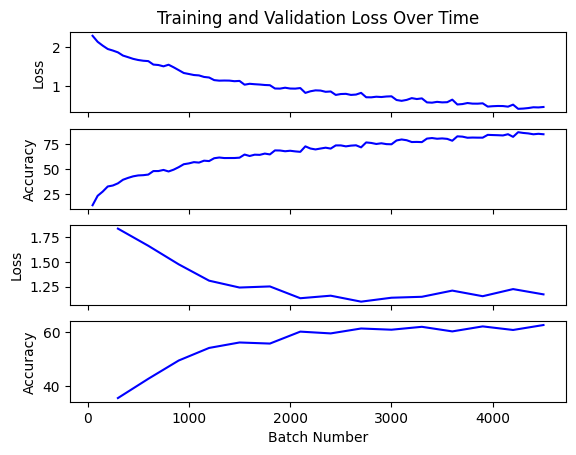

Epoch 16
Batch50, Loss: 0.393, Accuracy: 87.8%
Batch100, Loss: 0.396, Accuracy: 88.0%
Batch150, Loss: 0.396, Accuracy: 87.5%
Batch200, Loss: 0.408, Accuracy: 87.0%
Batch250, Loss: 0.431, Accuracy: 85.7%
Batch300, Loss: 0.450, Accuracy: 85.3%
Val Loss: 1.289, Val Accuracy: 60.5%
*****************************************



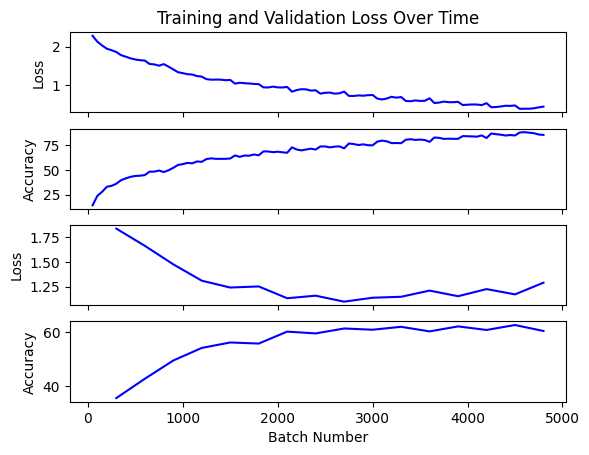

Epoch 17
Batch50, Loss: 0.355, Accuracy: 89.2%
Batch100, Loss: 0.358, Accuracy: 89.1%
Batch150, Loss: 0.383, Accuracy: 88.1%
Batch200, Loss: 0.366, Accuracy: 88.6%
Batch250, Loss: 0.370, Accuracy: 88.3%
Batch300, Loss: 0.388, Accuracy: 87.5%
Val Loss: 1.355, Val Accuracy: 60.6%
*****************************************



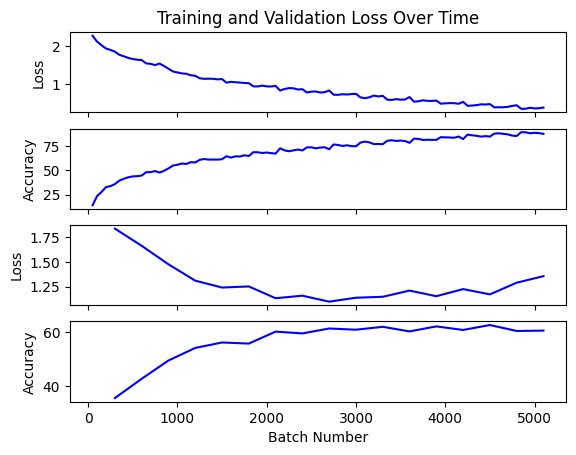

Epoch 18
Batch50, Loss: 0.330, Accuracy: 90.1%
Batch100, Loss: 0.330, Accuracy: 90.1%
Batch150, Loss: 0.341, Accuracy: 89.2%
Batch200, Loss: 0.345, Accuracy: 89.1%
Batch250, Loss: 0.345, Accuracy: 89.2%
Batch300, Loss: 0.379, Accuracy: 88.3%
Val Loss: 1.345, Val Accuracy: 60.3%
*****************************************



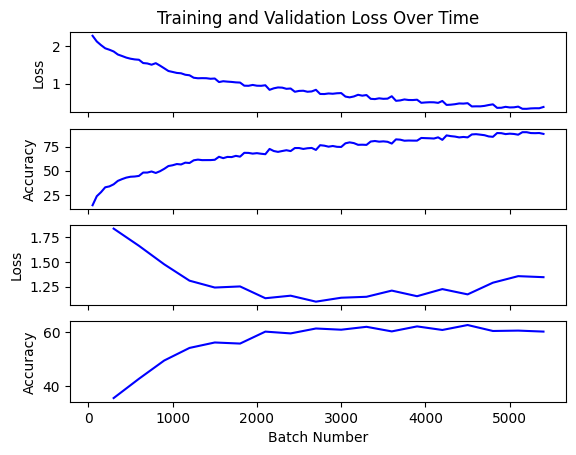

Epoch 19
Batch50, Loss: 0.278, Accuracy: 91.8%
Batch100, Loss: 0.286, Accuracy: 91.7%
Batch150, Loss: 0.283, Accuracy: 91.2%
Batch200, Loss: 0.307, Accuracy: 90.1%
Batch250, Loss: 0.330, Accuracy: 89.3%
Batch300, Loss: 0.366, Accuracy: 88.5%
Val Loss: 1.312, Val Accuracy: 61.8%
*****************************************



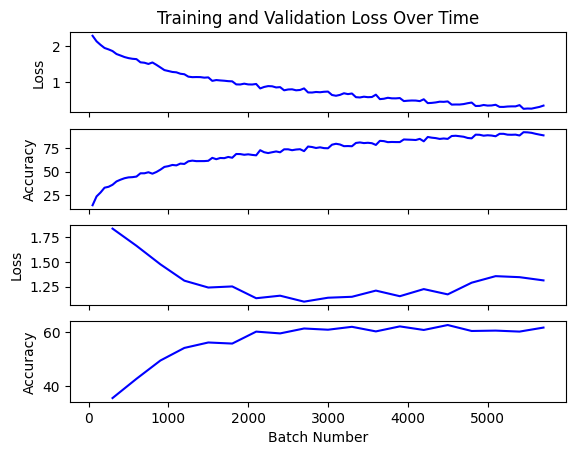

Epoch 20
Batch50, Loss: 0.279, Accuracy: 91.6%
Batch100, Loss: 0.267, Accuracy: 92.0%
Batch150, Loss: 0.278, Accuracy: 91.4%
Batch200, Loss: 0.280, Accuracy: 91.3%
Batch250, Loss: 0.289, Accuracy: 91.0%
Batch300, Loss: 0.308, Accuracy: 90.5%
Val Loss: 1.361, Val Accuracy: 61.6%
*****************************************



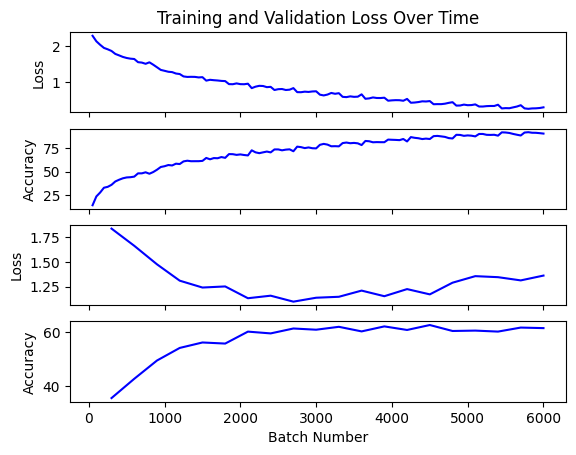

Epoch 21
Batch50, Loss: 0.230, Accuracy: 93.4%
Batch100, Loss: 0.244, Accuracy: 92.8%
Batch150, Loss: 0.248, Accuracy: 92.7%
Batch200, Loss: 0.258, Accuracy: 91.9%
Batch250, Loss: 0.275, Accuracy: 91.3%
Batch300, Loss: 0.278, Accuracy: 91.0%
Val Loss: 1.377, Val Accuracy: 61.5%
*****************************************



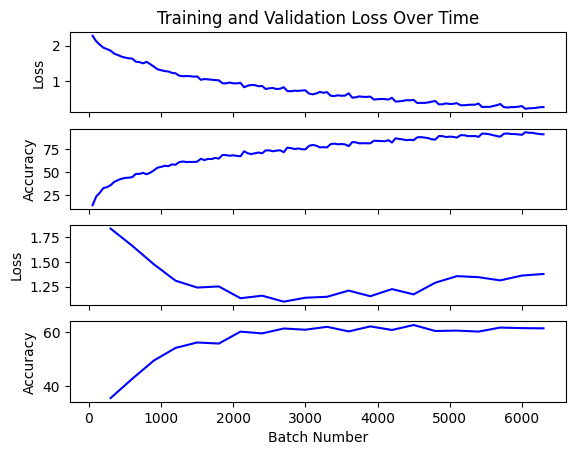

Epoch 22
Batch50, Loss: 0.215, Accuracy: 94.0%
Batch100, Loss: 0.203, Accuracy: 94.0%
Batch150, Loss: 0.226, Accuracy: 93.1%
Batch200, Loss: 0.251, Accuracy: 92.5%
Batch250, Loss: 0.238, Accuracy: 92.7%
Batch300, Loss: 0.257, Accuracy: 91.8%
Val Loss: 1.421, Val Accuracy: 62.1%
*****************************************



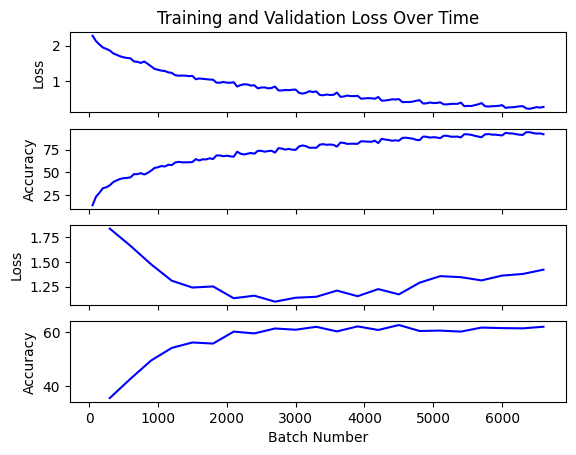

Epoch 23
Batch50, Loss: 0.206, Accuracy: 94.1%
Batch100, Loss: 0.211, Accuracy: 93.7%
Batch150, Loss: 0.198, Accuracy: 94.0%
Batch200, Loss: 0.212, Accuracy: 93.8%
Batch250, Loss: 0.223, Accuracy: 93.2%
Batch300, Loss: 0.243, Accuracy: 92.8%
Val Loss: 1.564, Val Accuracy: 59.9%
*****************************************



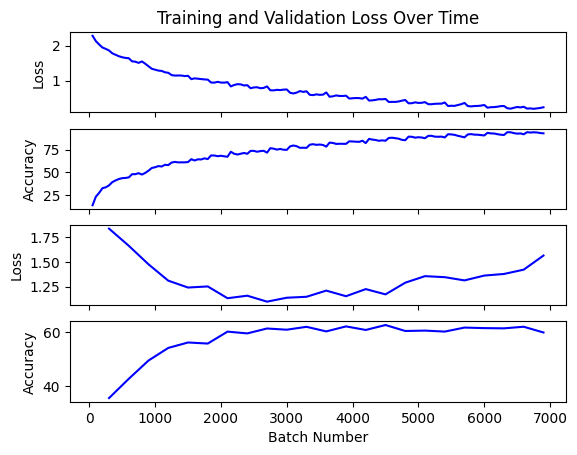

Epoch 24
Batch50, Loss: 0.192, Accuracy: 94.2%
Batch100, Loss: 0.191, Accuracy: 94.5%
Batch150, Loss: 0.199, Accuracy: 94.1%
Batch200, Loss: 0.200, Accuracy: 93.9%
Batch250, Loss: 0.217, Accuracy: 93.4%
Batch300, Loss: 0.228, Accuracy: 92.8%
Val Loss: 1.522, Val Accuracy: 59.8%
*****************************************



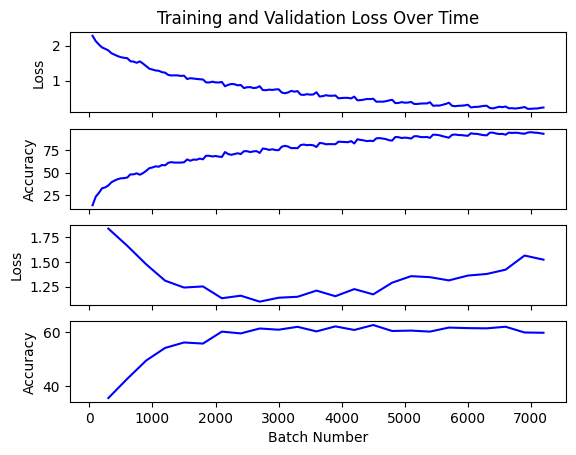

Epoch 25
Batch50, Loss: 0.180, Accuracy: 95.1%
Batch100, Loss: 0.168, Accuracy: 95.0%
Batch150, Loss: 0.174, Accuracy: 94.7%
Batch200, Loss: 0.201, Accuracy: 93.8%
Batch250, Loss: 0.185, Accuracy: 94.2%
Batch300, Loss: 0.216, Accuracy: 93.2%
Val Loss: 1.580, Val Accuracy: 59.9%
*****************************************



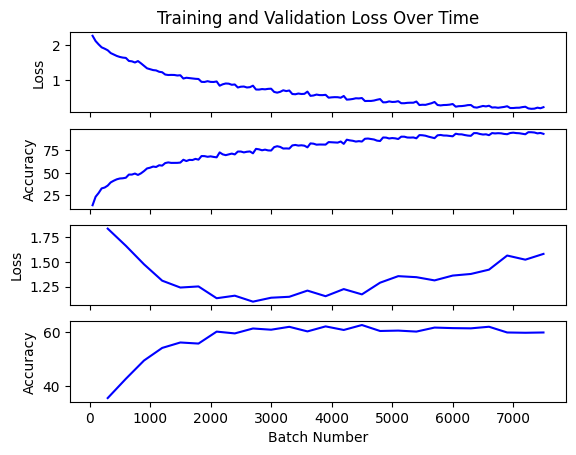

Epoch 26
Batch50, Loss: 0.154, Accuracy: 95.6%
Batch100, Loss: 0.145, Accuracy: 96.0%
Batch150, Loss: 0.164, Accuracy: 95.0%
Batch200, Loss: 0.183, Accuracy: 94.6%
Batch250, Loss: 0.193, Accuracy: 93.9%
Batch300, Loss: 0.191, Accuracy: 94.0%
Val Loss: 1.558, Val Accuracy: 60.9%
*****************************************



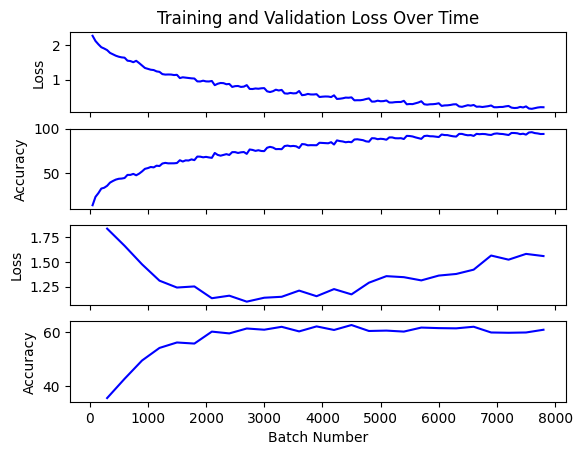

Epoch 27
Batch50, Loss: 0.156, Accuracy: 95.4%
Batch100, Loss: 0.170, Accuracy: 94.7%
Batch150, Loss: 0.150, Accuracy: 95.8%
Batch200, Loss: 0.144, Accuracy: 95.8%
Batch250, Loss: 0.163, Accuracy: 95.0%
Batch300, Loss: 0.181, Accuracy: 94.4%
Val Loss: 1.625, Val Accuracy: 60.0%
*****************************************



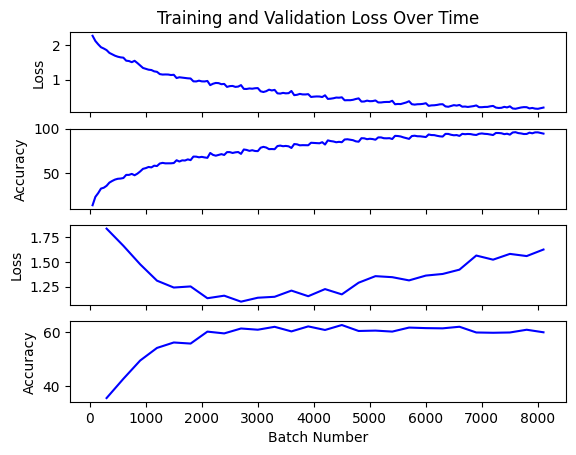

Epoch 28
Batch50, Loss: 0.132, Accuracy: 96.0%
Batch100, Loss: 0.143, Accuracy: 95.7%
Batch150, Loss: 0.140, Accuracy: 96.0%
Batch200, Loss: 0.155, Accuracy: 95.1%
Batch250, Loss: 0.175, Accuracy: 94.4%
Batch300, Loss: 0.164, Accuracy: 95.1%
Val Loss: 1.657, Val Accuracy: 60.1%
*****************************************



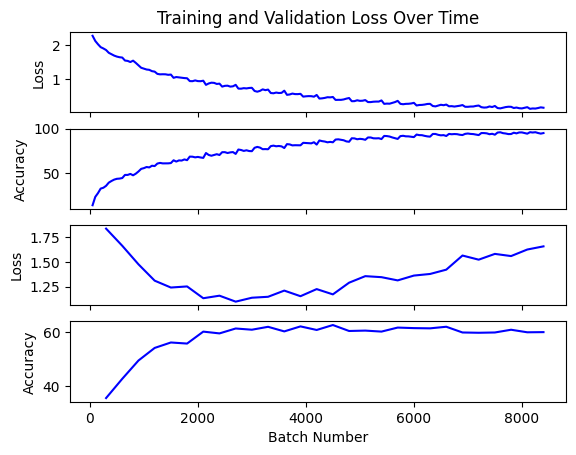

Epoch 29
Batch50, Loss: 0.141, Accuracy: 95.5%
Batch100, Loss: 0.144, Accuracy: 95.6%
Batch150, Loss: 0.144, Accuracy: 95.6%
Batch200, Loss: 0.151, Accuracy: 95.5%
Batch250, Loss: 0.165, Accuracy: 94.5%
Batch300, Loss: 0.175, Accuracy: 94.2%
Val Loss: 1.722, Val Accuracy: 59.6%
*****************************************



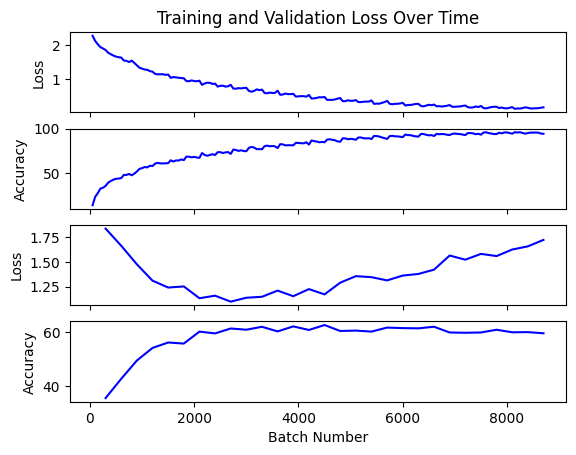

Epoch 30
Batch50, Loss: 0.139, Accuracy: 95.6%
Batch100, Loss: 0.151, Accuracy: 95.2%
Batch150, Loss: 0.152, Accuracy: 95.3%
Batch200, Loss: 0.149, Accuracy: 95.5%
Batch250, Loss: 0.160, Accuracy: 94.8%
Batch300, Loss: 0.172, Accuracy: 94.3%
Val Loss: 1.614, Val Accuracy: 61.2%
*****************************************



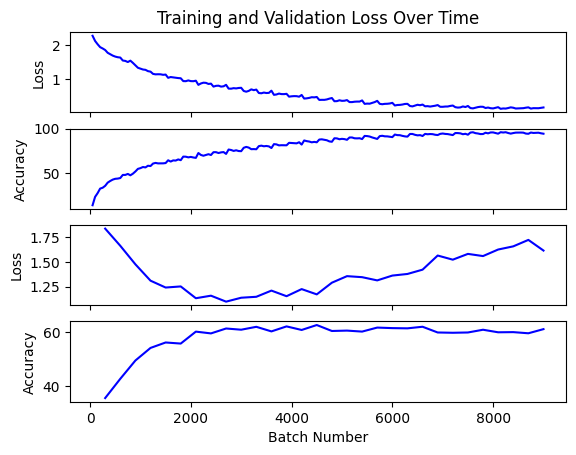

Epoch 31
Batch50, Loss: 0.122, Accuracy: 96.3%
Batch100, Loss: 0.130, Accuracy: 96.0%
Batch150, Loss: 0.141, Accuracy: 95.6%
Batch200, Loss: 0.145, Accuracy: 95.5%
Batch250, Loss: 0.157, Accuracy: 95.1%
Batch300, Loss: 0.172, Accuracy: 94.0%
Val Loss: 1.743, Val Accuracy: 59.2%
*****************************************



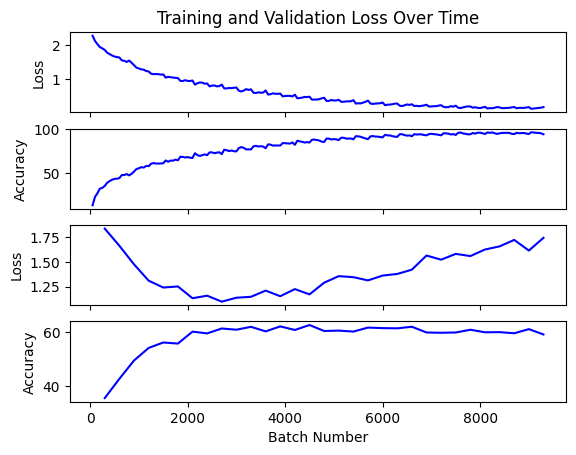

Epoch 32
Batch50, Loss: 0.139, Accuracy: 95.7%
Batch100, Loss: 0.133, Accuracy: 95.8%
Batch150, Loss: 0.122, Accuracy: 96.3%
Batch200, Loss: 0.134, Accuracy: 95.5%
Batch250, Loss: 0.125, Accuracy: 96.2%
Batch300, Loss: 0.163, Accuracy: 94.4%
Val Loss: 1.621, Val Accuracy: 61.7%
*****************************************



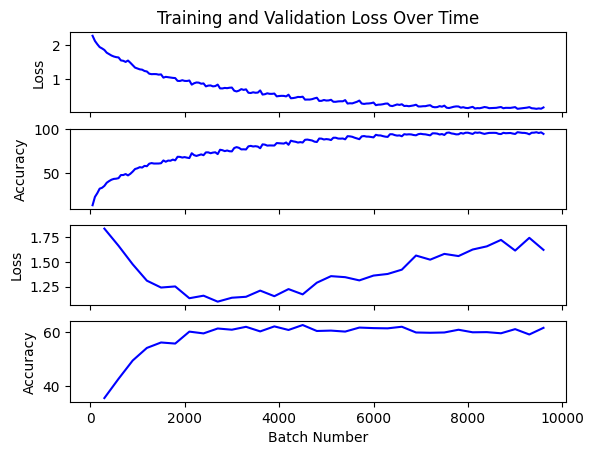

Epoch 33
Batch50, Loss: 0.119, Accuracy: 96.2%
Batch100, Loss: 0.127, Accuracy: 96.1%
Batch150, Loss: 0.132, Accuracy: 95.8%
Batch200, Loss: 0.127, Accuracy: 95.9%
Batch250, Loss: 0.120, Accuracy: 96.5%
Batch300, Loss: 0.130, Accuracy: 95.7%
Val Loss: 1.700, Val Accuracy: 60.9%
*****************************************



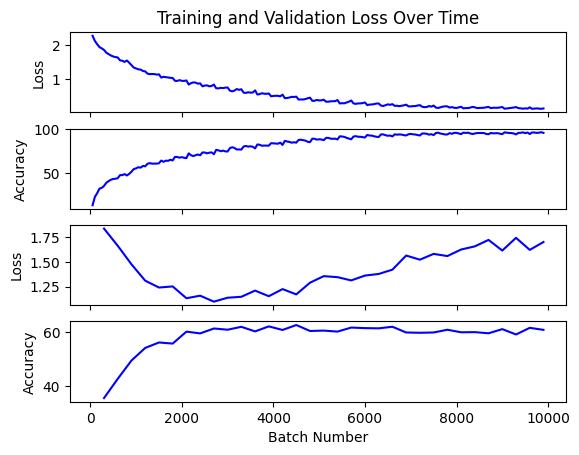

Epoch 34
Batch50, Loss: 0.096, Accuracy: 97.1%
Batch100, Loss: 0.101, Accuracy: 97.0%
Batch150, Loss: 0.096, Accuracy: 97.0%
Batch200, Loss: 0.119, Accuracy: 96.4%
Batch250, Loss: 0.128, Accuracy: 96.1%
Batch300, Loss: 0.138, Accuracy: 95.5%
Val Loss: 1.751, Val Accuracy: 60.3%
*****************************************



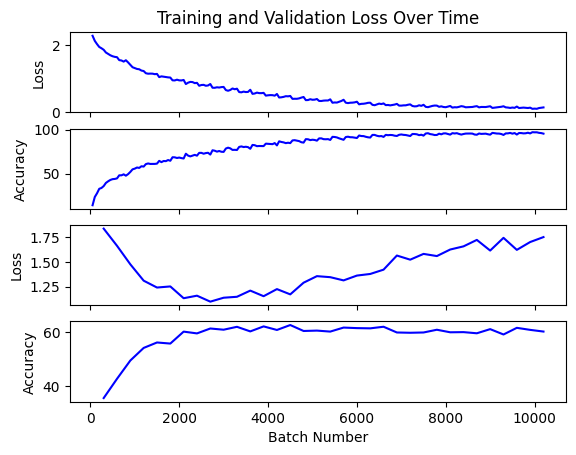

Epoch 35
Batch50, Loss: 0.111, Accuracy: 96.5%
Batch100, Loss: 0.093, Accuracy: 97.1%
Batch150, Loss: 0.110, Accuracy: 96.5%
Batch200, Loss: 0.120, Accuracy: 96.5%
Batch250, Loss: 0.125, Accuracy: 96.2%
Batch300, Loss: 0.140, Accuracy: 95.5%
Val Loss: 1.719, Val Accuracy: 60.8%
*****************************************



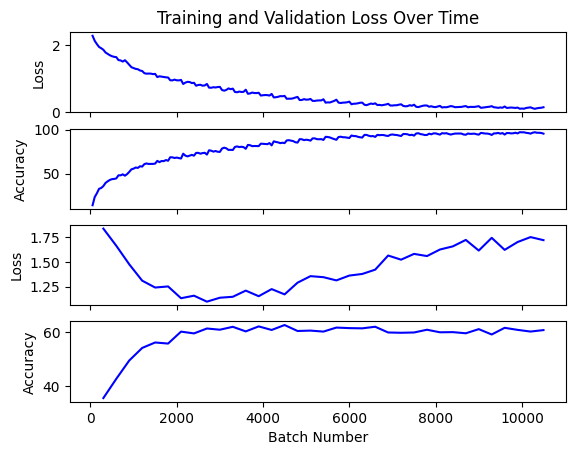

Epoch 36
Batch50, Loss: 0.144, Accuracy: 95.4%
Batch100, Loss: 0.127, Accuracy: 96.0%
Batch150, Loss: 0.118, Accuracy: 96.4%
Batch200, Loss: 0.137, Accuracy: 95.6%
Batch250, Loss: 0.127, Accuracy: 95.9%
Batch300, Loss: 0.143, Accuracy: 95.5%
Val Loss: 1.749, Val Accuracy: 60.3%
*****************************************



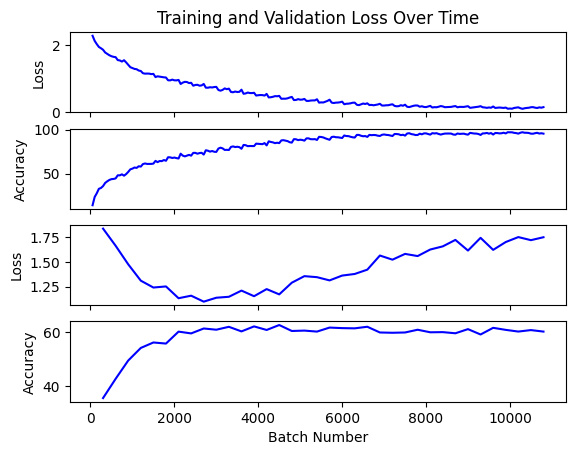

Epoch 37
Batch50, Loss: 0.107, Accuracy: 96.7%
Batch100, Loss: 0.095, Accuracy: 97.2%
Batch150, Loss: 0.101, Accuracy: 97.1%
Batch200, Loss: 0.105, Accuracy: 96.9%
Batch250, Loss: 0.117, Accuracy: 96.2%
Batch300, Loss: 0.124, Accuracy: 96.3%
Val Loss: 1.733, Val Accuracy: 61.6%
*****************************************



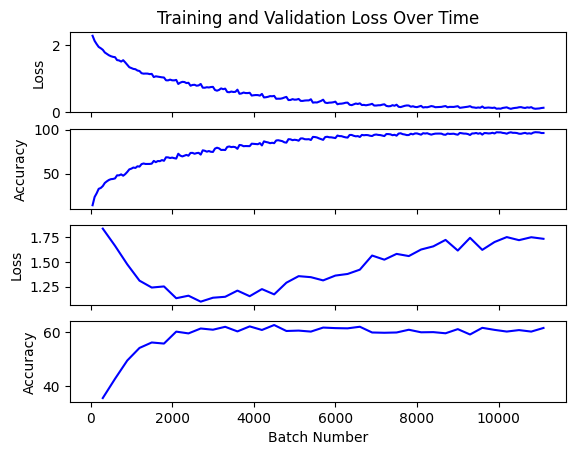

Epoch 38
Batch50, Loss: 0.092, Accuracy: 97.1%
Batch100, Loss: 0.088, Accuracy: 97.2%
Batch150, Loss: 0.099, Accuracy: 96.9%
Batch200, Loss: 0.104, Accuracy: 96.9%
Batch250, Loss: 0.113, Accuracy: 96.5%
Batch300, Loss: 0.124, Accuracy: 96.3%


KeyboardInterrupt: 

In [ ]:
#Sets up CNN, optimizer, and loss function
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)

batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 125
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(cnn, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(cnn, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}

for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")




In [ ]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
cnn.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 75.15900636025441


In [ ]:
torch.save(cnn, 'DeepCNNParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([CNN]):
    cnn = torch.load('DeepResNetParams.pth', weights_only=False)
cnn.to(device)

In [ ]:
test_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: horse
Guess label: horse


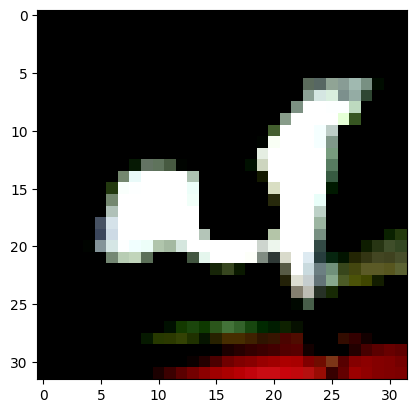

In [ ]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
cnn.train(False)
guess_labels = cnn(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))